## MGMT 190: Data and Programming for Analytics
## Group 4: Anna Zhang, Ying Jin, Sang Do, Anuj Shah, Milisha Merchant, Egemen Can Gok

Dataset: http://jmcauley.ucsd.edu/data/amazon/links.html

Citation:

Image-based Recommendations on Styles and Substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015

Inferring Networks of Substitutable and Complementary Products
J. McAuley, R. Pandey, J. Leskovec
Knowledge Discovery and Data Mining, 2015

In [1]:
# Import Statements

import json
import gzip # for opening .gz files

from IPython.display import HTML
from IPython.display import Image

%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_palette("coolwarm")
import matplotlib.pyplot as plt

import urllib
import urllib2
import bs4 # Beautiful Soup

from pandas import Series
import pandas as pd
from pandas import DataFrame

import re
import random

import time
import datetime

In [2]:
def get_json(file_name):
    response = open(file_name + ".json", "r")
    result = []
    for json_line in response.readlines():
        json_text = json_line.decode(encoding = 'utf-8')
        result.append(json.loads(str(json_text)))
    return result

def sort_reviews_by_rating(file_name):
    return sorted(get_json(file_name), key = lambda x: x["overall"])

def review_stats(json_list):
    print "Number of Reviews: {}".format(len(json_list))
    print "Average Rating (of those who left a review): {}\n".format(np.mean(np.array([x["overall"] for x in json_list])).round(2)) 
    
def has_helpful(data):
    return data["helpful"][1] != 0

def helpfulness(data):
    return (float(data["helpful"][0])/float(data["helpful"][1]))

def helpfulness_and_rating(json_list):    
    helpful_data = []
    print "Helpfulness:"
    for i in range(1,5+1):
        helpful = [helpfulness(x) for x in json_list if has_helpful(x) and x["overall"] == i]
        helpful_data.append(np.mean(np.array(helpful))*100)
        print "Helpfulness of {}-Star Reviews: {}%".format(i, (helpful_data[i-1]).round(2))
    print ""
    plt.bar(range(1,6), helpful_data, color = 'y')
    plt.xlabel("Rating (out of 5)")
    plt.ylabel("Helpfulness %")
    plt.title("Helpfulness of Reviews (based on rating)")
    plt.show()
    
def count_words(data):
    return len(data['reviewText'].split())

def helpfulness_and_text(json_list):
    text_helpful = [count_words(x) for x in json_list if has_helpful(x) and count_words(x) >= 1000]
    helpful= [helpfulness(x)*100 for x in json_list if has_helpful(x) and count_words(x) >= 1000]
    plt.plot(text_helpful,helpful, 'r.')
    plt.xlabel("Number of Words")
    plt.ylabel("Helpfulness %")
    plt.title("Helpfulness of Reviews (based on number of words)")
    plt.show()
    
def ratings_over_time(json_list, time_period):
    rating_avg = []
    for year in time_period:
        review_times = [x["overall"] for x in json_list if int(x["reviewTime"].split()[2]) == year]
        rating_avg.append(np.mean(np.array(review_times)))
    plt.bar(time_period, rating_avg)
    plt.xlabel("Year")
    plt.ylabel("Average Rating")
    plt.title("Average Ratings Over Time")
    plt.show()
    
def lowest_reviews(json_list, n):
    print("Summaries of Lowest Reviews:") # n reviews with the lowest ratings
    i = 1
    for review_object in result[:n]:
        print(str(i) + ") " + review_object["summary"])
        i += 1
    print("\n")
    
def highest_reviews(json_list, n):
    print("Summaries of Highest Reviews:") # n reviews with the highest ratings
    i = 1
    for highest in result[-n:]:
        print(str(i) + ") " + highest["summary"])
        i += 1
    print("\n")

In [3]:
# Convert JSON to CSV.
y = get_json("Cell_Phones_and_Accessories")
df = pd.DataFrame(y)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,120401325X,"[0, 0]",4.0,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400
1,120401325X,"[0, 0]",5.0,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600
2,120401325X,"[0, 0]",5.0,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800
3,120401325X,"[4, 4]",4.0,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600
4,120401325X,"[2, 3]",5.0,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600


In [4]:
# Add Sentimemnt Analysis
df['sentiment'] = df.overall.apply(lambda overall: "positive" if overall > 3 else "negative" if overall < 3 else "neutral")
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,sentiment
0,120401325X,"[0, 0]",4.0,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,positive
1,120401325X,"[0, 0]",5.0,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,positive
2,120401325X,"[0, 0]",5.0,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,positive
3,120401325X,"[4, 4]",4.0,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,positive
4,120401325X,"[2, 3]",5.0,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,positive


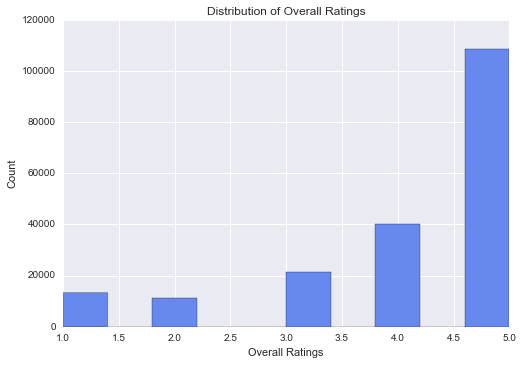

In [5]:
# Histogram of Overall Ratings
fig = df.overall.hist()
fig.set_xlabel('Overall Ratings')
fig.set_ylabel('Count')
fig.set_title("Distribution of Overall Ratings")

In [6]:
# Drop row where sentiment = neutral.
df = df[df.sentiment != 'neutral']

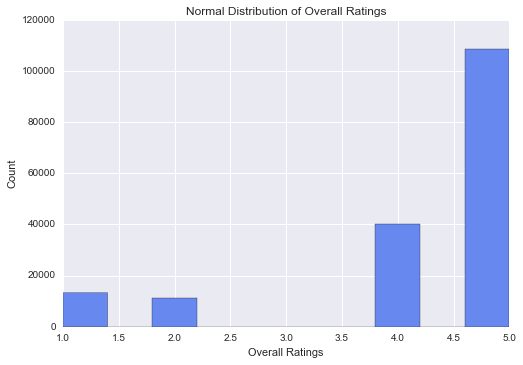

In [7]:
# Histogram of Overall Ratings After Removing Three-Star Ratings
fig = df.overall.hist()
fig.set_xlabel('Overall Ratings')
fig.set_ylabel('Count')
fig.set_title("Normal Distribution of Overall Ratings")

In [8]:
# Clean up text data from summary column.

import string
import nltk

sum_re = re.compile('[^a-z]+')
def sum_cleanup(summary):
    summary = summary.lower()
    summary = sum_re.sub(' ', summary).strip()
    return summary

df["summary_clean"] = df["summary"].apply(sum_cleanup)

In [9]:
df_positive = df[df.sentiment == "positive"]
df_negative = df[df.sentiment == "negative"]

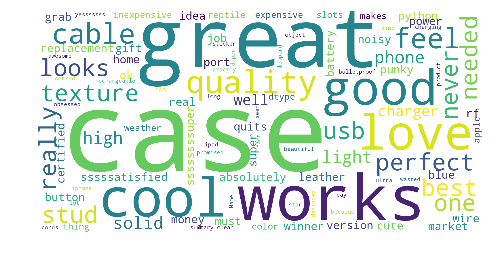

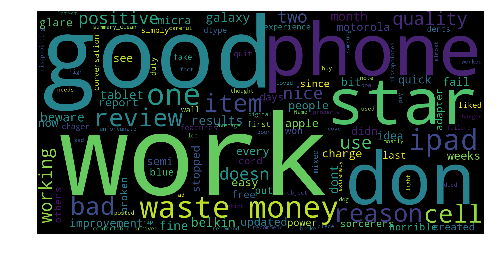

In [10]:
# Create WordCloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# Positive WordCloud
pos_wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=400, max_font_size=100, scale=5, random_state=1).generate(str(df_positive.summary_clean))
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

# Negative WordCloud
neg_wordcloud = WordCloud(background_color='black', stopwords=stopwords, max_words=400, max_font_size=100, scale=5, random_state=1).generate(str(df_negative.summary_clean))
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

train, test = train_test_split(df, train_size=0.7, random_state=1)
print("%d Items in Training Data, %d Items in Testing Data" % (len(train), len(test)))

count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 2))
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(train["summary_clean"])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(test["summary_clean"])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

y_train = train["sentiment"]
y_test = test["sentiment"]

prediction = dict()

121099 Items in Training Data, 51901 Items in Testing Data


In [12]:
# Applying Multinomial Naïve Bayes Learning Method
from sklearn.naive_bayes import MultinomialNB
multi = MultinomialNB()
multi_result = multi.fit(X_train_tfidf, y_train)
prediction['Multinomial'] = multi_result.predict(X_test_tfidf)

# Applying Bernoulli Naïve Bayes Learning Method
from sklearn.naive_bayes import BernoulliNB
ber = BernoulliNB()
ber_result = ber.fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = ber_result.predict(X_test_tfidf)

# Applying Logistic Regression learning Method
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=1e5)
log_result = log.fit(X_train_tfidf, y_train)
prediction['Logistic'] = log_result.predict(X_test_tfidf)

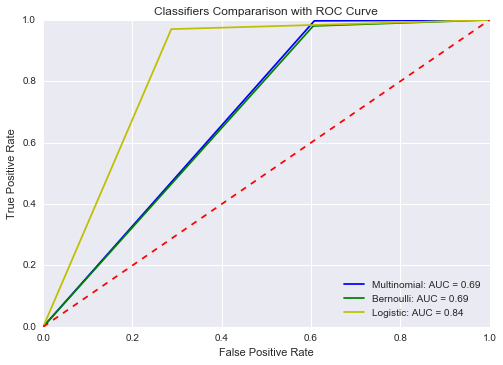

In [13]:
# Classifiers Comparison with ROC Curve 
# The curve with the highest AUC value will be the best model.

from sklearn.metrics import roc_curve, auc

def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC = %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers Compararison with ROC Curve')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1],[0,1],'r--')
plt.show()

In [14]:
from sklearn import metrics

print 'Accuracy Score',metrics.accuracy_score(y_test,predicted).round(4)*100,"%"
print('Reporting...')

labels = list(set(df.sentiment))
print(metrics.classification_report(y_test, predicted, target_names=labels))

Accuracy Score 93.41 %
Reporting...
             precision    recall  f1-score   support

   positive       0.79      0.71      0.75      7255
   negative       0.95      0.97      0.96     44646

avg / total       0.93      0.93      0.93     51901



In [15]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(data = list(zip(words, log_result.coef_[0])), columns = ['Feature', 'Coefficient'])
feature_coefs.sort_values(by='Coefficient')

,Feature,Coefficient
106529,worst,-30.250513
44379,horrible,-27.971530
90933,terrible,-27.354251
62903,not,-27.280691
50617,junk,-26.727471
106051,work yes,-25.774631
26335,doesn work,-24.314987
106740,wouldn,-24.017785
26576,dont buy,-23.926490
26338,doesnt,-23.510242


In [16]:
# Testing Coefficient of a Term
feature_coefs[feature_coefs.Feature == 'battery']

,Feature,Coefficient
8884,battery,1.720063


In [17]:
# Display Full Review Text
pd.set_option('display.max_colwidth', -1)
df.reviewText.head()

0    They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again                                                                                      
1    These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :)                                                                                                                   
2    These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!                                                                                                             
3    Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen prot

In [18]:
# Create a function to test whether a review text is positive or negative.
def test(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = (model.predict_proba(sample_tfidf)[0])*100
    print("Sample Estimated as %s: Negative Probability %.2f%%, Positive Probability %.2f%%" % (result.upper(), prob[0], prob[1]))

In [19]:
# Testing Some Review Text
print "This is the first battery case I have had for my Galaxy S4. The S4 fits very well, is slim and doesn't add much weight to the Galaxy S4. It doubles the battery life. You can charge either the battery, the phone or both. There is a handy on-off switch with leds to indicate the level of charge.The battery case came on time and was packaged well. Well worth the price."
print
test(log, "This is the first battery case I have had for my Galaxy S4. The S4 fits very well, is slim and doesn't add much weight to the Galaxy S4. It doubles the battery life. You can charge either the battery, the phone or both. There is a handy on-off switch with leds to indicate the level of charge.The battery case came on time and was packaged well. Well worth the price.  ")
print
print "They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again."
print
test(log, "They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again.")
print
print "It worked for the first week then it only charge my phone to 20%. it is a waste of money."
print
test(log, "It worked for the first week then it only charge my phone to 20%. it is a waste of money.")
print
print "I am disappointed that the 1A didn't work with my iPad.  That's what I get for buying a cheap adapter."
print
test(log, "I am disappointed that the 1A didn't work with my iPad.  That's what I get for buying a cheap adapter.")

This is the first battery case I have had for my Galaxy S4. The S4 fits very well, is slim and doesn't add much weight to the Galaxy S4. It doubles the battery life. You can charge either the battery, the phone or both. There is a handy on-off switch with leds to indicate the level of charge.The battery case came on time and was packaged well. Well worth the price.

Sample Estimated as POSITIVE: Negative Probability 0.01%, Positive Probability 99.99%

They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again.

Sample Estimated as POSITIVE: Negative Probability 0.10%, Positive Probability 99.90%

It worked for the first week then it only charge my phone to 20%. it is a waste of money.

Sample Estimated as NEGATIVE: Negative Probability 99.97%, Positive Probability 0.03%

I am disappointed that the 1A didn't work with my iPad.  That's what I get for buying a

In [20]:
# Testing for Different Models with the Same Text
test(multi,"I am disappointed that the 1A didn't work with my iPad.  That's what I get for buying a cheap adapter.")
test(ber,"I am disappointed that the 1A didn't work with my iPad.  That's what I get for buying a cheap adapter.")
test(log,"I am disappointed that the 1A didn't work with my iPad.  That's what I get for buying a cheap adapter.")

Sample Estimated as POSITIVE: Negative Probability 24.42%, Positive Probability 75.58%
Sample Estimated as NEGATIVE: Negative Probability 100.00%, Positive Probability 0.00%
Sample Estimated as NEGATIVE: Negative Probability 66.44%, Positive Probability 33.56%
